In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import models, transforms

# Define the train and test directories
train_dir = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/train'
test_dir = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/test'

# Define the transformation for the input images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per VGG16 requirements
])

# Load a pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Function to extract features from an image
def extract_features(image_path, model, preprocess):
    img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img_tensor)  # Extract features
    return features.squeeze().numpy()

# Initialize lists to store features and labels
features = []
labels = []

# Loop through the train and test directories
# Assuming directories are structured with 'benign' and 'malignant' folders
for class_folder in ['benign', 'malignant']:
    class_folder_path = os.path.join(train_dir, class_folder)
    class_label = 0 if class_folder == 'benign' else 1  # Assign 0 for benign, 1 for malignant

    for img_name in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img_name)
        extracted_features = extract_features(img_path, model, preprocess)  # Extract features
        features.append(extracted_features)
        labels.append(class_label)

# Convert the extracted features and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Save extracted features and labels for future use
np.save('train_features_BreaKHis_VGG16.npy', X)
np.save('train_labels_BreaKHis_VGG16.npy', y)

# Repeat the process for the test directory
features = []
labels = []

for class_folder in ['benign', 'malignant']:
    class_folder_path = os.path.join(test_dir, class_folder)
    class_label = 0 if class_folder == 'benign' else 1

    for img_name in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img_name)
        extracted_features = extract_features(img_path, model, preprocess)
        features.append(extracted_features)
        labels.append(class_label)

# Convert the extracted test features and labels to numpy arrays
X_test = np.array(features)
y_test = np.array(labels)

# Save test features and labels
np.save('test_features_BreaKHis_VGG16.npy', X_test)
np.save('test_labels_BreaKHis_VGG16.npy', y_test)

print("Feature extraction complete, files saved.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


Feature extraction complete, files saved.


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

**Load Features and Labels**

In [5]:
# Load the saved training features and labels
X_train = np.load('train_features_BreaKHis_VGG16.npy')
y_train = np.load('train_labels_BreaKHis_VGG16.npy')

# Load the saved test features and labels
X_test = np.load('test_features_BreaKHis_VGG16.npy')
y_test = np.load('test_labels_BreaKHis_VGG16.npy')

Train the Classifier

In [6]:
# Create the SVM model
svm_model = SVC(kernel='linear', probability=True)  # Using a linear kernel

# Train the model
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [11]:
# Calculate cross-validated training accuracy
training_accuracy = cross_val_score(svm_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Training Accuracy (CV Mean): {np.mean(training_accuracy):.4f}")

Training Accuracy (CV Mean): 0.8927


Evaluate the Model

In [12]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8767

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       118
           1       0.90      0.92      0.91       247

    accuracy                           0.88       365
   macro avg       0.86      0.85      0.86       365
weighted avg       0.88      0.88      0.88       365



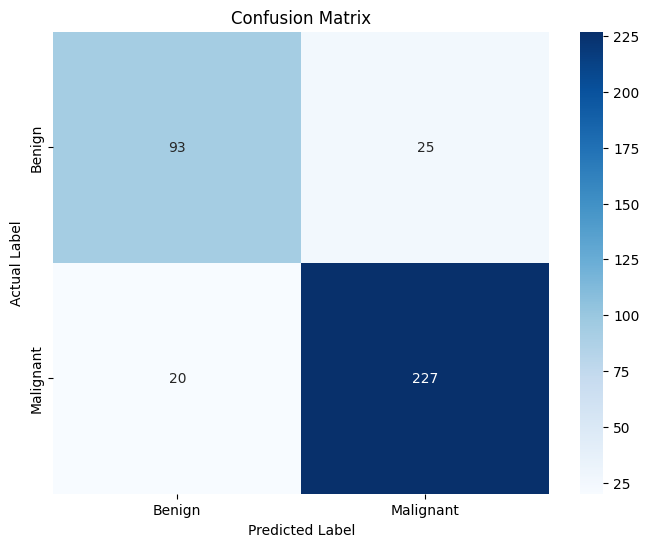

In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()